In [2]:
import cv2
import os
import numpy as np

def load_images_from_folders(base_folder):
    images = []
    image_paths = []
    for label in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, label)
        for filename in os.listdir(folder_path):
            if filename[2] == '1':
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    images.append(img)
                    image_paths.append(img_path)
    return images, image_paths

folder = 'D:\ANU\Semester_3\Advanced_Computing_Project\Project_Repo\pilot data\data'
images, image_paths = load_images_from_folders(folder)
print(f"Loaded {len(images)} images")


Loaded 181 images


In [3]:
sift = cv2.SIFT_create()

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

descriptors_list = []
for image in images:
    descriptors = extract_features(image)
    if descriptors is not None:
        descriptors_list.append(descriptors)

print(f"Extracted descriptors for {len(descriptors_list)} images")


Extracted descriptors for 181 images


In [4]:
from sklearn.cluster import MiniBatchKMeans, KMeans

# Stack all descriptors vertically
all_descriptors = np.vstack(descriptors_list)
print(f"Stacked all descriptors into array of shape {all_descriptors.shape}")

# Set number of clusters
num_clusters = 30

kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=200).fit(all_descriptors)
print(f"Clustered descriptors into {num_clusters} clusters")

def create_bovw(descriptors, kmeans, num_clusters):
    if descriptors is None:
        return np.zeros(num_clusters)
    
    # predict cluster index for each descriptor
    clusters = kmeans.predict(descriptors)
    histogram = np.bincount(clusters, minlength=num_clusters)
    
    return histogram


# build BoVW histograms
bovw_list = [create_bovw(descriptors, kmeans, num_clusters) for descriptors in descriptors_list]

print(f"Created BoVW histograms for {len(bovw_list)} images")


Stacked all descriptors into array of shape (6333, 128)
Clustered descriptors into 30 clusters
Created BoVW histograms for 181 images


Feature matrix shape: (181, 30)


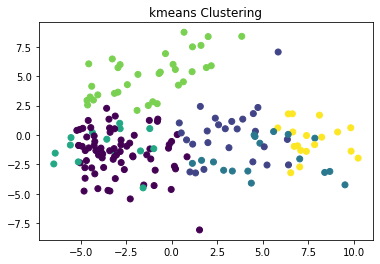

In [8]:
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt


X = np.array(bovw_list)
print(f"Feature matrix shape: {X.shape}")

# reduce dimensionality with PCA
image_kmeans = MiniBatchKMeans(n_clusters=6, random_state=0).fit(X)
image_labels = image_kmeans.labels_

pca = PCA(n_components=2) 
X = pca.fit_transform(X)

# Scatter the points
plt.scatter(X[:, 0], X[:, 1], c=image_labels, cmap='viridis')

plt.title('kmeans Clustering')
plt.show()

In [9]:
print(image_paths.__len__())

181


In [10]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
import os

# 1. extract true labels
true_labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
print(f"unique true labels extracted：{set(true_labels)}")

# 2. index encode true and cluster labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(true_labels)))}
print(f"true label to index affine：{label_to_index}")

true_labels_encoded = np.array([label_to_index[label] for label in true_labels])
print(f"true label encoded：{true_labels_encoded}")

# encode cluster labels into integers
cluster_labels = np.array(image_labels)
unique_cluster_labels = np.unique(cluster_labels)
cluster_label_to_index = {label: idx for idx, label in enumerate(sorted(unique_cluster_labels))}
print(f"cluster label to index affine：{cluster_label_to_index}")

cluster_labels_encoded = np.array([cluster_label_to_index[label] for label in cluster_labels])
print(f"cluster label encoded：{cluster_labels_encoded}")

# 3. Create confusion matrix
num_classes = max(true_labels_encoded.max(), cluster_labels_encoded.max()) + 1
print(f"number of classes：{num_classes}")

confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
print(f"shape of confusion matrix：{confusion_matrix.shape}")

for true_label, cluster_label in zip(true_labels_encoded, cluster_labels_encoded):
    confusion_matrix[true_label][cluster_label] += 1

# 4. find the best mapping between cluster labels and true labels
row_ind, col_ind = linear_sum_assignment(-confusion_matrix)

# create a mapping from cluster label to true label
cluster_to_true_label = dict()
for cluster_label, true_label in zip(col_ind, row_ind):
    cluster_to_true_label[cluster_label] = true_label

# 5. map cluster labels to true labels and calculate accuracy
mapped_cluster_labels = [cluster_to_true_label[label] for label in cluster_labels_encoded]
accuracy = accuracy_score(true_labels_encoded, mapped_cluster_labels)

print(f"The accuracy of clustering is: {accuracy * 100:.2f}%")


unique true labels extracted：{'D', 'B', 'C', 'Monica'}
true label to index affine：{'B': 0, 'C': 1, 'D': 2, 'Monica': 3}
true label encoded：[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3]
cluster label to index affine：{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
cluster label encoded：[0 1 5 0 1 3 0 1 5 2 0 0 3 0 0 0 0 1 3 4 0 1 1 1 0 2 3 3 0 2 0 2 5 0 2 0 0
 5 0 1 0 1 1 0 0 0 0 0 5 1 0 3 5 3 3 1 0 5 1 0 1 0 0 0 5 0 5 0 0 1 5 0 0 5
 2 0 1 5 2 2 5 0 0 0 1 0 2 5 0 2 5 5 0 2 2 0 0 0 2 5 0 1 1 2 0 0 3 0 3 1 0
 0 0 0 0 0 0 0 0 2 3 1 2 0 1 0 5 2 0 3 3 3 4 0 0 1 4 0 4 4 4 0 4 0 4 4 0 4
 4 4 4 4 1 0 4 4 4 0 4 4 4 4 1 4 4 0 4 4 4 4 0 0 4 4 4 4 4 0 4 1 0]
number of classes：6
shape of confusi

Cluster 0


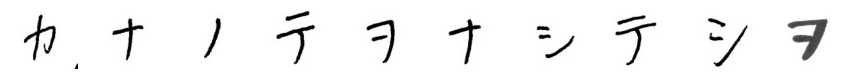

Cluster 1


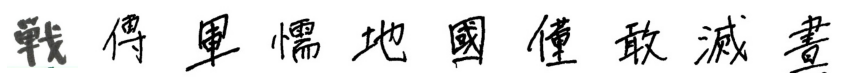

Cluster 2


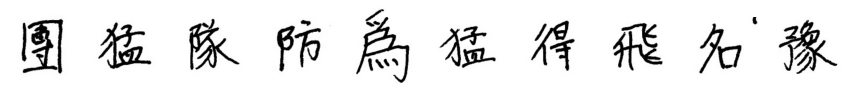

Cluster 3


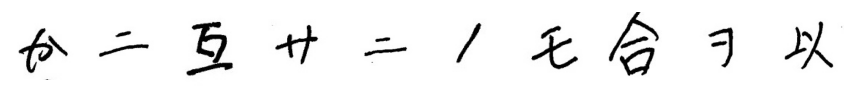

Cluster 4


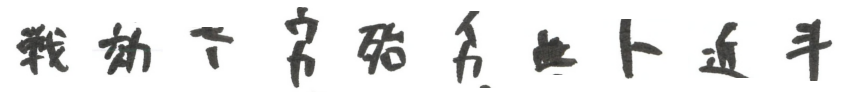

Cluster 5


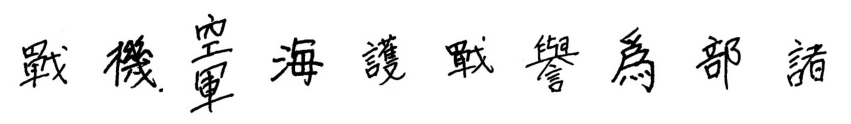

Cluster 6


<Figure size 1080x360 with 0 Axes>

Cluster 7


<Figure size 1080x360 with 0 Axes>

Cluster 8


<Figure size 1080x360 with 0 Axes>

Cluster 9


<Figure size 1080x360 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import random

def plot_images_by_cluster(image_paths, labels, cluster_id):
    cluster_images = [img_path for img_path, label in zip(image_paths, labels) if label == cluster_id]
    num_images = min(len(cluster_images), 6)
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(cluster_images, num_images)):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# show images in each cluster
for cluster_id in range(6):
    print(f"Cluster {cluster_id}")
    plot_images_by_cluster(image_paths, image_labels, cluster_id)
